In [1]:
import pandas as pd

paths = {
    "train": "/Users/manangarg/Desktop/ANLP/Unknown_Tokens/data/english/train.csv",
    "val": "/Users/manangarg/Desktop/ANLP/Unknown_Tokens/data/english/val.csv",
    "semeval_train": "/Users/manangarg/Desktop/ANLP/Unknown_Tokens/data/english/semeval/train.csv",
    "semeval_val": "/Users/manangarg/Desktop/ANLP/Unknown_Tokens/data/english/semeval/val.csv",
}

for name, path in paths.items():
    df = pd.read_csv(path)
    counts = df["label"].value_counts().to_dict()
    zeros = int(counts.get(0, 0))
    ones = int(counts.get(1, 0))
    print(f"{name}: 0s={zeros}, 1s={ones}, total={zeros + ones}")



train: 0s=23862, 1s=20401, total=44263
val: 0s=6108, 1s=4957, total=11065
semeval_train: 0s=1551, 1s=1517, total=3068
semeval_val: 0s=372, 1s=394, total=766


In [2]:
# Visualization setup and stats table
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
except Exception:
    # Install if missing (safe to re-run)
    %pip -q install matplotlib seaborn
    import matplotlib.pyplot as plt
    import seaborn as sns

from IPython.display import display
import numpy as np

sns.set_theme(style="whitegrid")

# Reuse paths defined earlier
assert "paths" in globals(), "Run the first cell that defines `paths` before this one."

# Load datasets and compute counts/percentages

def load_datasets(paths):
    datasets = {}
    for name, path in paths.items():
        df = pd.read_csv(path)
        if "label" not in df.columns or "text" not in df.columns:
            raise ValueError(f"{name} missing required columns `text` and `label`.")
        df["label"] = pd.to_numeric(df["label"], errors="coerce").fillna(-1).astype(int)
        df["text"] = df["text"].astype(str)
        datasets[name] = df
    return datasets

datasets = load_datasets(paths)

rows = []
for name, df in datasets.items():
    counts = df["label"].value_counts().reindex([0, 1], fill_value=0)
    total = int(counts.sum())
    for label in [0, 1]:
        cnt = int(counts.loc[label])
        pct = (cnt / total * 100.0) if total > 0 else 0.0
        rows.append({
            "dataset": name,
            "label": label,
            "count": cnt,
            "percent": pct,
            "total": total,
        })

stats_df = pd.DataFrame(rows).sort_values(["dataset", "label"]) 
print("Label distribution summary (per dataset):")
display(stats_df.reset_index(drop=True))


Note: you may need to restart the kernel to use updated packages.
Label distribution summary (per dataset):


,dataset,label,count,percent,total
0,semeval_train,0,1551,50.554107,3068
1,semeval_train,1,1517,49.445893,3068
2,semeval_val,0,372,48.563969,766
3,semeval_val,1,394,51.436031,766
4,train,0,23862,53.909586,44263
5,train,1,20401,46.090414,44263
6,val,0,6108,55.201085,11065
7,val,1,4957,44.798915,11065


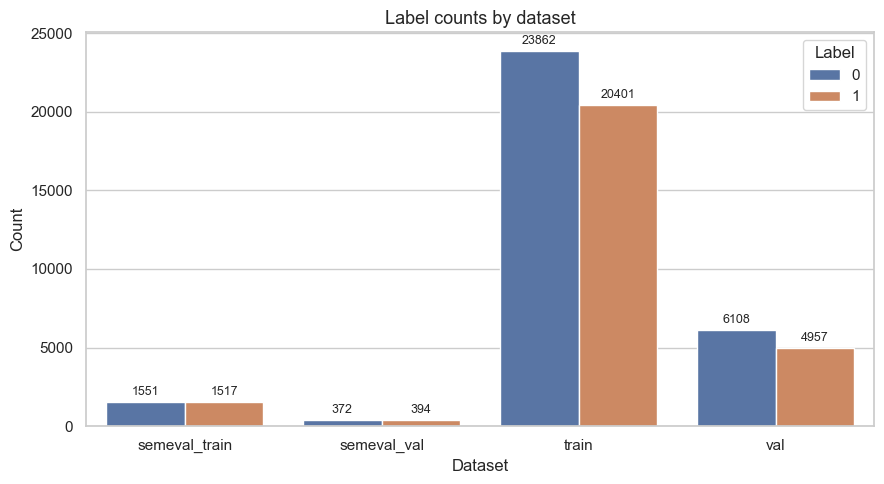

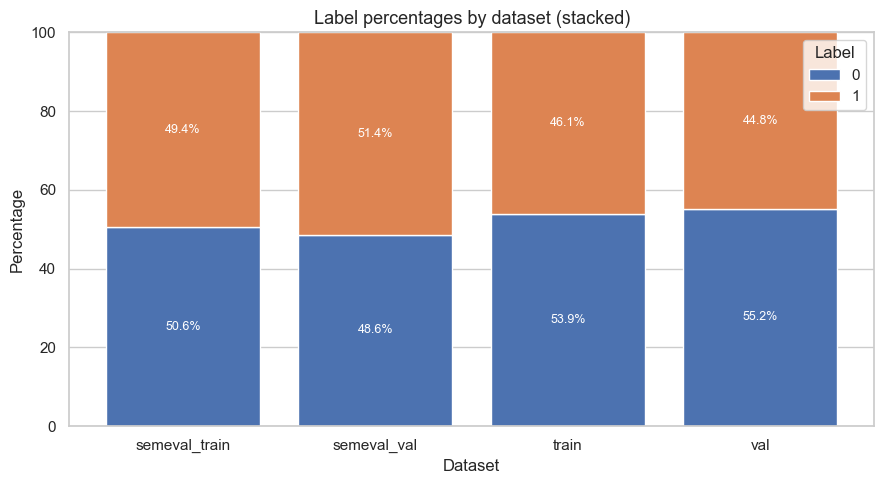

In [3]:
# Bar charts: counts and percentages
palette = {0: "#4C72B0", 1: "#DD8452"}

# Counts barplot
fig, ax = plt.subplots(figsize=(9, 5))
sns.barplot(data=stats_df, x="dataset", y="count", hue="label", palette=palette, ax=ax)
ax.set_title("Label counts by dataset", fontsize=13)
ax.set_xlabel("Dataset")
ax.set_ylabel("Count")
# Annotate bars with counts
for container in ax.containers:
    ax.bar_label(container, fmt="%d", padding=3, fontsize=9)
ax.legend(title="Label")
plt.tight_layout()
plt.show()

# Percentage stacked bars
pct_pivot = (stats_df.pivot(index="dataset", columns="label", values="percent")
             .fillna(0.0)
             .reindex(columns=[0, 1]))

fig, ax = plt.subplots(figsize=(9, 5))
bottom = np.zeros(len(pct_pivot))
for lbl in [0, 1]:
    vals = pct_pivot[lbl].values
    ax.bar(pct_pivot.index, vals, bottom=bottom, color=palette[lbl], label=str(lbl))
    # Annotate with percentages
    for i, (x, y0, y) in enumerate(zip(pct_pivot.index, bottom, vals)):
        if y > 0:
            ax.text(i, y0 + y / 2, f"{y:.1f}%", ha="center", va="center", color="white", fontsize=9)
    bottom += vals

ax.set_title("Label percentages by dataset (stacked)", fontsize=13)
ax.set_xlabel("Dataset")
ax.set_ylabel("Percentage")
ax.set_ylim(0, 100)
ax.legend(title="Label")
plt.tight_layout()
plt.show()


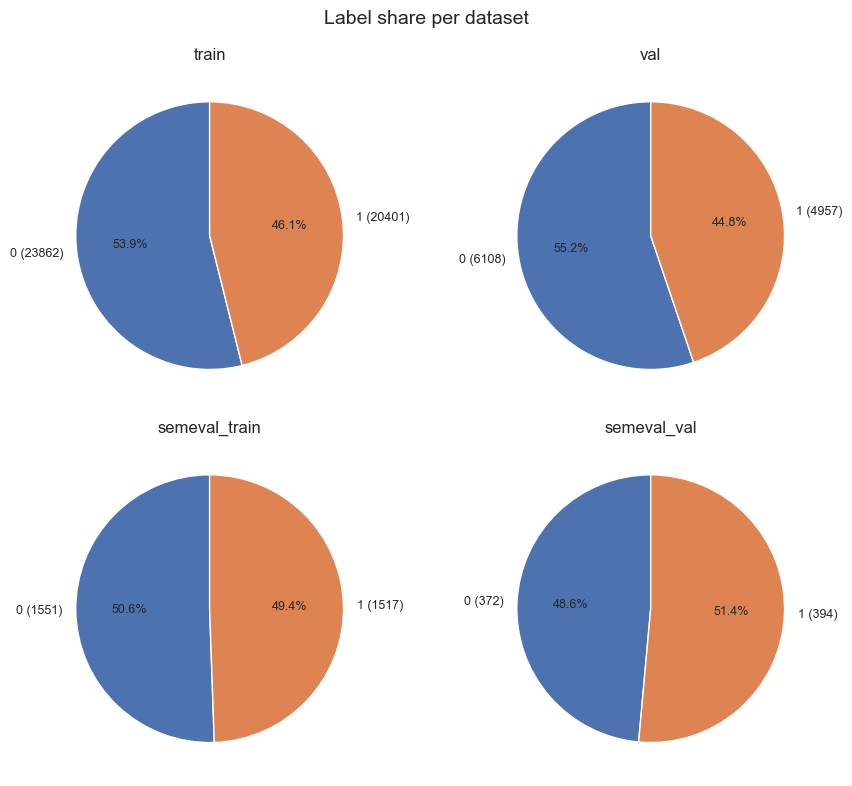

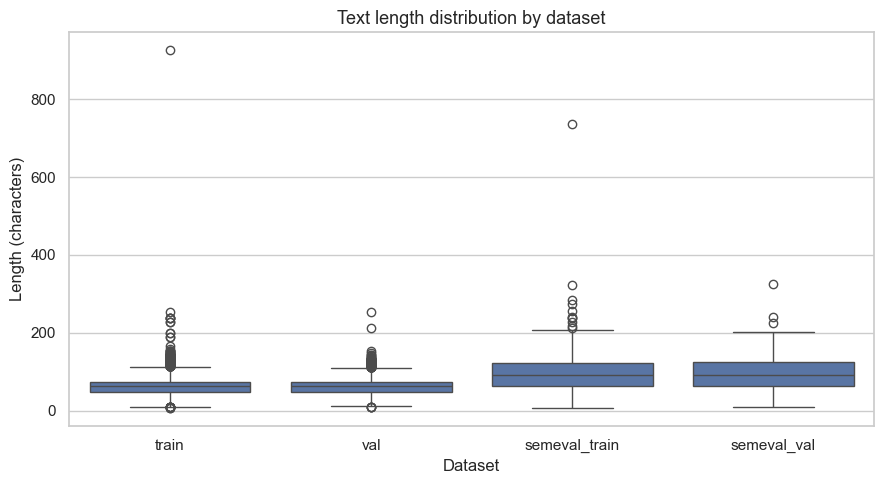

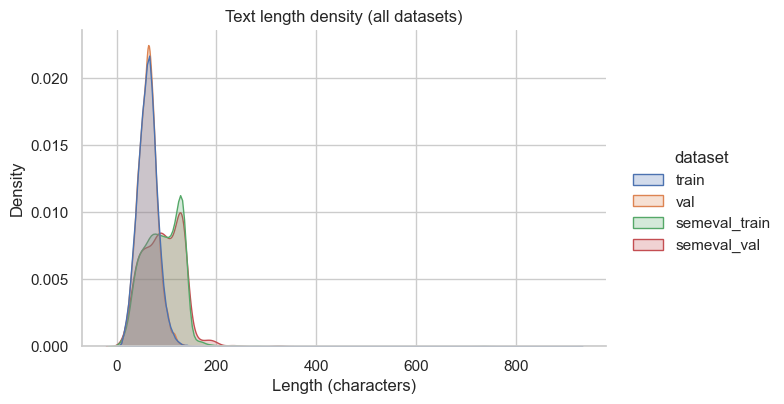

In [4]:
# Pie charts and text length distributions
# Pie charts (2x2)
fig, axes = plt.subplots(2, 2, figsize=(9, 8))
axes = axes.flatten()
for ax, (name, df) in zip(axes, datasets.items()):
    counts = df["label"].value_counts().reindex([0, 1], fill_value=0)
    sizes = counts.values
    labels = [f"0 ({counts[0]})", f"1 ({counts[1]})"]
    ax.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90,
           colors=["#4C72B0", "#DD8452" ], textprops={"fontsize":9})
    ax.set_title(name, fontsize=12)

# Hide any unused subplots (if fewer than 4 datasets)
for j in range(len(datasets), 4):
    fig.delaxes(axes[j])

plt.suptitle("Label share per dataset", fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

# Text length distribution by dataset
length_frames = []
for name, df in datasets.items():
    length_frames.append(pd.DataFrame({"dataset": name, "length": df["text"].str.len()}))
length_df = pd.concat(length_frames, ignore_index=True)

fig, ax = plt.subplots(figsize=(9, 5))
sns.boxplot(data=length_df, x="dataset", y="length", ax=ax)
ax.set_title("Text length distribution by dataset", fontsize=13)
ax.set_xlabel("Dataset")
ax.set_ylabel("Length (characters)")
plt.tight_layout()
plt.show()

# Optional: KDE overlay of text lengths (comment out if slow)
sns.displot(data=length_df, x="length", hue="dataset", kind="kde", fill=True,
            common_norm=False, height=4, aspect=1.6)
plt.title("Text length density (all datasets)")
plt.xlabel("Length (characters)")
plt.show()
